# Solution 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# 1. Modeling the Volatility Smile

## Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swapa rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

## Rate Data

The file `data/cap_quotes_2024-02-20.xlsx` gives 
* SOFR swap rates, 
* their associated discount factors
* their associated forward interest rates.

You will not need the cap data (flat or forward vols) for this problem.
* This cap data would be helpful in calibrating a binomial tree, but this problem focuses on Black's formula and SABR.

## The Swaption

Consider the following swaption with the following features:
* underlying is a fixed-for-floating (SOFR) swap
* the underlying swap has **quarterly** payment frequency
* this is a **payer** swaption, which gives the holder the option to **pay** the fixed swap rate and receive SOFR.

## 1.1
Calculate the (relevant) forward swap rate. That is, the one-year forward 4-year swap rate.

## 1.2
Price the swaptions at the quoted implied volatilites and corresponding strikes, all using the just-calculated forward swap rate as the underlying.

## 1.3
To consider how the expiration and tenor matter, calculate the prices of a few other swaptions for comparison. 
* No need to get other implied vol quotes--just use the ATM implied vol you have for the 1x2 above. (Here we are just interested in how Black's formula changes with changes in tenor and expiration.
* No need to calculate for all the strikes--just do the ATM strike.

Alternate swaptions
* The 3mo x 4yr swaption
* The 2yr x 4yr swaption
* the 1yr x 2yr swaption

Report these values and compare them to the price of the `1y x 4y` swaption.

***

# **<span style="color:red">Solutions</span>**

In [16]:

import sys
import os
# sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'cmds/'))
sys.path.append(os.path.dirname(os.getcwd()))
from cmds.binomial import *

import numpy as np
import pandas as pd

from cmds.ficcvol import *
from cmds.binomial import *
from cmds.ratecurves import *

In [17]:
from datetime import date, datetime
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# **<span style="color:red">Solution 1</span>**

In [18]:
DATE = '2024-02-20'
freqcurve = 4

SWAP_TYPE = 'SOFR'
QUOTE_STYLE = 'black'
RELATIVE_STRIKE = 0

expry = 1
tenor = 4

freqswap = 4
isPayer=True
N = 100

In [19]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

Topt = expry
Tswap = Topt+tenor

fwdrate = curves['forwards'][Topt]

fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)

## **<span style="color:red">1.1</span>**

In [20]:
display(f'The forward swap rate is {fwdswap:.2%}')

'The forward swap rate is 3.67%'

## **<span style="color:red">1.2</span>**

### Import and Process Quoted Vols

In [51]:
voldata = pd.read_excel('../data/swaption_vol_data.xlsx')
volquote = voldata.query(f'model=="{QUOTE_STYLE}"').query(f'reference=="{SWAP_TYPE}"').query(f'date=="{DATE}"')
idx = (volquote['expiration']==expry) & (volquote['tenor']==tenor)
volquote = volquote.loc[idx]
volquote.index = ['implied vol']

volquote
voldata


,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
0,SOFR,swaption,black,2024-02-20,1,4,54.54,40.37,35.94,34.23,32.83,31.71,30.86,29.83,29.54


In [22]:
strikerange = np.array(volquote.columns[-9:].tolist())
vols = volquote[strikerange]
vols /= 100
strikes = fwdswap + strikerange/100/100
idstrike = np.where(strikerange==RELATIVE_STRIKE)[0][0]

idstrikeATM = np.where(strikerange==0)[0][0]

if QUOTE_STYLE == 'normal':
    vols /= 100 * fwdrate

capvol = curves.loc[Topt,'fwd vols']

strikeATM = strikes[idstrikeATM]
volATM = vols.iloc[0,idstrikeATM]

### Use Black's Formula

In [57]:
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap
blacks_quotes = vols.copy()
blacks_quotes.loc['price'] = N * blacks_formula(Topt,vols,strikes,fwdswap,discount,isCall=isPayer)[0]
blacks_quotes.loc['strike'] = strikes
blacks_quotes = blacks_quotes.loc[['strike','implied vol','price']]

blacks_quotes.style.format('{:.4f}')


tenor
1.25    0.942608
1.50    0.933499
1.75    0.924774
2.00    0.916212
2.25    0.908230
2.50    0.900188
2.75    0.892076
3.00    0.883906
3.25    0.876134
3.50    0.868539
3.75    0.860726
4.00    0.852910
4.25    0.845410
4.50    0.838026
4.75    0.830464
5.00    0.822816
Name: discounts, dtype: float64

## **<span style="color:red">1.3</span>**

In [53]:
expiries = [.25,1,2,1]
tenors = [4,4,4,2]
fwdswaps = np.full(len(expiries),np.nan)

blacks_quotes_alt = pd.DataFrame(dtype=float,columns=['expiry','tenor','price'])
    
for i in range(len(fwdswaps)):
    fwdswaps[i] = calc_fwdswaprate(curves['discounts'], expiries[i], expiries[i]+tenors[i], freqswap=freqswap)
    
    period0 = curves.index.get_loc(expiries[i])
    period1 = curves.index.get_loc(expiries[i]+tenors[i])+1
    step_i = round(freqcurve/freqswap)

    discount_i = curves['discounts'].iloc[period0+step_i : period1 : step_i].sum()/freqswap

    blacks_quotes_alt.loc[i,['expiry','tenor']] = [expiries[i],tenors[i]]
    blacks_quotes_alt.loc[i,'price'] = N * blacks_formula(expiries[i],volATM,strikeATM,fwdswaps[i],discount_i,isCall=isPayer)

    
def highlight_row(row):
    if row.name == 1:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)
    
blacks_quotes_alt.style.apply(highlight_row,axis=1).format({'expiry':'{:.2f}', 'tenor':'{:.2f}', 'price':'{:.4f}'})

array([nan, nan, nan, nan])

***

# 2. Pricing w/ BDT

Use the data in `cap_curves_2024-02-20.xlsx`.

## 2.1

Calibrate the BDT Tree
* theta to fit the term structure discounts.
* sigma to fit the fwd vols from the cap data.

Report the rate tree through $T=5$. Report trees for rates compounded
* continuously
* annually

## 2.2

Use a tree to price a vanilla fixed-rate, 5-year bond with coupon rate equal to the forward swap rate calculated in problem `1.1.`

## 2.3

We will calculate the binomial tree for the 5-year swap, but here we do so by valuing the swap as...

$$\text{payer swap} = \text{floating rate note} - \text{fixed-rate bond}$$

Recall for the Floating-Rate Note:
* It has par value of 100 at each reset date.
* Every node is a reset date given the assumptions of the swap timing.

Report the tree for the 5-year swap.

## 2.4



Report the binomial tree for the one-year European swaption on a 4-year swap.
* At expiration, the swap tree from 2.3 will have 4 years left, as desired for pricing the 1y-4y swaption.

## 2.5

Compare the pricing of the 1y4y swaption from Black's formula in Section 1 vs the binomial tree.

## 2.6

Reprice the swaption using the BDT tree, but this time assuming it is **american**-style exercise.

***

# **<span style="color:red">Solution 2</span>**

## **<span style="color:red">2.1</span>**

#### Interpolate curves to Tree Grid

In [25]:
FREQTREE = 4
dt = 1/FREQTREE

newgrid = np.arange(dt,curves.index[-1]+dt,dt).round(6)
curvesint = pd.DataFrame(dtype=float, columns=curves.columns, index=newgrid)
cols_interp = ['swap rates','flat vols','fwd vols']

# interpolate
curvesint = pd.concat([curvesint,curves],axis=0)
curvesint = curvesint.interpolate(method='cubicspline',fill_value='extrapolate',limit_direction='both')
curvesint = curvesint.loc[newgrid,:]
curvesint = curvesint[~curvesint.index.duplicated()].sort_index()

# compute derived curves
curvesint['discounts'] = ratecurve_to_discountcurve(curvesint['swap rates'],n_compound=FREQTREE)
curvesint['forwards'] = ratecurve_to_forwardcurve(curvesint['swap rates'],n_compound=FREQTREE)

# forward vol is derived but can't extract curve--interpolate and adjust front to first flat vol
id0 = curves['flat vols'].dropna().index[0]
curvesint.loc[:id0,['flat vols','fwd vols']] = curves.loc[id0,'flat vols']

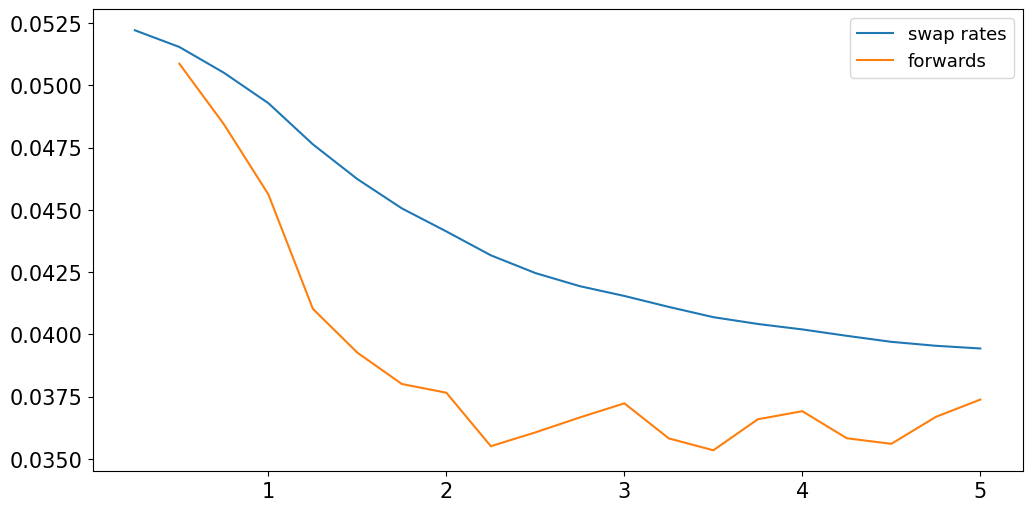

In [26]:
curvesint[['swap rates','forwards']].loc[:Tswap].plot();

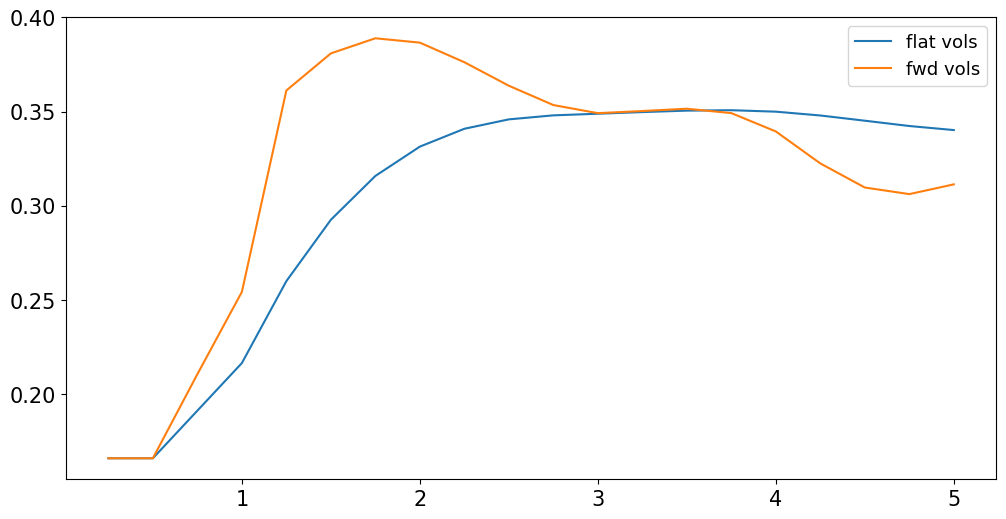

In [27]:
curvesint[['flat vols','fwd vols']].loc[:Tswap].plot();

#### Market Rates

In [28]:
quotes = curves['discounts']
swaprate = calc_swaprate(quotes, Tswap, freqswap=freqswap)
fwdswap = calc_fwdswaprate(quotes, Topt, Tswap, freqswap=freqswap)
fwdrate = curves['forwards'][Topt]

#### Build BDT Rate Tree

In [59]:
sigmas = curvesint['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]
sigmas.index = sigmas.index.to_numpy().round(6)

theta, ratetree = estimate_theta(sigmas.loc[:Tswap],100*curvesint.loc[:Tswap,'discounts'])
ratetree

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,0.051874,0.054736,0.056989,0.059217,0.059410,0.064159,0.070858,0.080900,0.088669,0.105371,0.126050,0.151273,0.172605,0.202390,0.249329,0.299666,0.346657,0.410519,0.503879,0.611453
1,NaN,0.046363,0.048271,0.050158,0.050321,0.054344,0.060019,0.068524,0.075105,0.089252,0.106767,0.128132,0.146201,0.171430,0.211188,0.253825,0.293627,0.347720,0.426798,0.517916
2,NaN,NaN,0.039102,0.040631,0.040763,0.044022,0.048619,0.055509,0.060840,0.072299,0.086488,0.103795,0.118431,0.138868,0.171075,0.205613,0.237856,0.281674,0.345732,0.419543
3,NaN,NaN,NaN,0.031507,0.031610,0.034137,0.037701,0.043044,0.047178,0.056064,0.067067,0.080488,0.091838,0.107685,0.132660,0.159443,0.184445,0.218424,0.268098,0.325335
4,NaN,NaN,NaN,NaN,0.022026,0.023787,0.026271,0.029994,0.032874,0.039066,0.046733,0.056084,0.063993,0.075036,0.092438,0.111101,0.128523,0.152199,0.186812,0.226695
5,NaN,NaN,NaN,NaN,NaN,0.016252,0.017949,0.020492,0.022460,0.026691,0.031929,0.038318,0.043722,0.051266,0.063156,0.075907,0.087810,0.103986,0.127635,0.154884
6,NaN,NaN,NaN,NaN,NaN,NaN,0.012165,0.013889,0.015223,0.018090,0.021640,0.025971,0.029633,0.034747,0.042805,0.051447,0.059515,0.070478,0.086507,0.104975
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009435,0.010341,0.012289,0.014701,0.017643,0.020131,0.023605,0.029079,0.034950,0.040430,0.047878,0.058767,0.071313
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007099,0.008436,0.010091,0.012111,0.013818,0.016203,0.019961,0.023991,0.027753,0.032865,0.040339,0.048952


## **<span style="color:red">2.2 and 2.3</span>**

In [62]:
freqcpn = freqswap
strike = strikes[idstrike]
cpn = strike

wrapper_bond = lambda r: payoff_bond(r, 1/FREQTREE, facevalue=N * (1+cpn/freqcpn))
cftree = construct_bond_cftree(Tswap, FREQTREE, cpn, cpn_freq=freqcpn, face=N)
# cftree
bondtree = bintree_pricing(payoff=wrapper_bond, interest_rate_tree=ratetree, cftree=cftree)
# bondtree
if isPayer:
    swaptree = (N-bondtree)
else:
    swaptree = (bondtree-N)
    
format_bintree(swaptree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,98.678058,96.544155,94.304080,91.931973,89.419221,86.714078,83.923519,81.099088,78.326651,75.579831,73.065898,70.896282,69.199604,67.957582,67.386638,67.883859,69.653154,72.835923,78.074023,86.612618
1,NaN,101.551914,99.608526,97.546456,95.350814,92.964260,90.472712,87.911679,85.349283,82.748727,80.292517,78.077709,76.221903,74.708346,73.746347,73.721371,74.840410,77.245758,81.506094,88.661856
2,NaN,NaN,104.027023,102.253155,100.367756,98.315510,96.162984,93.933143,91.675969,89.349097,87.103064,85.015251,83.180529,81.574284,80.377053,79.931618,80.425624,81.999890,85.180289,90.869379
3,NaN,NaN,NaN,106.008611,104.390352,102.640018,100.807916,98.908648,96.979447,94.976817,93.018321,91.162472,89.483682,87.949902,86.698913,86.010762,86.033880,86.870203,88.948334,93.034948
4,NaN,NaN,NaN,NaN,107.467375,105.961003,104.395422,102.780363,101.141969,99.447167,97.780358,96.183594,94.711045,93.337869,92.164560,91.398113,91.146934,91.481492,92.707044,95.357692
5,NaN,NaN,NaN,NaN,NaN,108.324444,106.954473,105.550155,104.129823,102.669986,101.229888,99.839191,98.536233,97.302908,96.209969,95.404268,94.961559,94.928607,95.515686,97.085092
6,NaN,NaN,NaN,NaN,NaN,NaN,108.740334,107.484692,106.218644,104.926239,103.648735,102.407034,101.228066,100.099352,99.069979,98.241801,97.666369,97.373789,97.505781,98.304034
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.822293,107.662362,106.484960,105.318853,104.178871,103.084020,102.026091,101.039251,100.193787,99.524578,99.050858,98.867478,99.134802
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.660109,107.561068,106.470277,105.398302,104.358651,103.346035,102.384524,101.523019,100.785435,100.184295,99.783577,99.690554


#### Alt Calculation

If Time grid aligns with swap frequency, calculate directly with binomial tree and verify.

In [33]:
if freqswap==FREQTREE:
    swaprate_val = strike
    payoff = lambda r: payoff_swap(r,swaprate_val,freqswap,ispayer=isPayer)
    cftree, refratetree = construct_swap_cftree(ratetree,swaprate_val,freqswap=freqswap,T=Tswap,freq=FREQTREE,ispayer=isPayer)
    swaptree_alt = bintree_pricing(payoff=payoff, interest_rate_tree=ratetree, undertree= refratetree, cftree=cftree, cfdelay=True)

    display(f'Difference in swap price across two methods: {swaptree.iloc[0,0]-swaptree_alt.iloc[0,0]:.4f}')

'Difference in swap price across two methods: 0.0000'

## **<span style="color:red">2.4</span>**

In [35]:
payoff_swaption = lambda s: np.maximum(s,0)
swaptiontree = bintree_pricing(payoff=payoff_swaption,interest_rate_tree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,1.73,2.94,4.83,7.50,10.58
1,,0.56,1.13,2.30,4.65
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


## **<span style="color:red">2.5</span>**

In [36]:
comp = blacks_quotes.iloc[:,[idstrike]].copy()
comp.columns = ['black']
comp.loc['price','tree'] = swaptiontree.iloc[0,0]
comp.loc['implied vol', 'tree'] = capvol
comp.loc['strike','tree'] = fwdswap
comp = comp.T

comp.style.format('{:.4f}')

,strike,implied vol,price
black,0.0367,0.3283,1.6874
tree,0.0367,0.2543,1.7284


## **<span style="color:red">2.6</span>**

In [38]:
swaptiontree_american = bintree_pricing(payoff=payoff_swaption,interest_rate_tree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree.loc[:,:Topt].dropna(how='all'),style='american')
format_bintree(swaptiontree_american)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,2.00,3.46,5.70,8.07,10.58
1,,0.60,1.21,2.45,4.65
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


***

# 3. Midcurve Swaptions

## 3.1 

Use the BDT tree from section 2 to price a **european** midcurve swaption 1y$\rightarrow$2y$\rightarrow$2y.

## 3.2

Price the **american** midcurve swaption 1y$\rightarrow$2y$\rightarrow$2y.

***

# **<span style="color:red">Solution 3</span>**

## **<span style="color:red">3.1</span>**

In [39]:
Topt=1
Tmid=2
Ttenor=2

In [42]:
if freqswap==FREQTREE:
    swaprate_val = strike
    payoff = lambda r: payoff_swap(r,swaprate_val,freqswap,ispayer=isPayer)
    cftree, refratetree = construct_swap_cftree(ratetree,swaprate_val,freqswap=freqswap,T=Tswap,freq=FREQTREE,ispayer=isPayer)

    # midcurve swap
    cftree_mid = cftree.copy()
    cftree_mid.loc[:,:(Topt+Tmid-1/freqswap)] *= 0

    swaptree_mid = bintree_pricing(payoff=payoff, interest_rate_tree=ratetree, undertree= refratetree, cftree=cftree_mid, cfdelay=True)

In [44]:
payoff_swaption = lambda s: np.maximum(s,0)
swaptiontree_mid = bintree_pricing(payoff=payoff_swaption,interest_rate_tree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree_mid.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree_mid)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,0.86,1.48,2.46,3.88,5.63
1,,0.27,0.55,1.11,2.24
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


## **<span style="color:red">3.2</span>**

In [46]:
swaptiontree_mid_american = bintree_pricing(style='american',payoff=payoff_swaption,interest_rate_tree=ratetree.loc[:,:Topt].dropna(how='all'),undertree=swaptree_mid.loc[:,:Topt].dropna(how='all'))
format_bintree(swaptiontree_mid_american)

time,0.00,0.25,0.50,0.75,1.00
state,,,,,
0,0.86,1.48,2.46,3.88,5.63
1,,0.27,0.55,1.11,2.24
2,,,0.00,0.00,0.00
3,,,,0.00,0.00
4,,,,,0.00


***